In [2]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

from statsmodels.tsa.stattools import adfuller
!pip install pmdarima --quiet
import pmdarima as pm

In [17]:
pwd

'C:\\Sumit_jupyter'

In [52]:
#df = pd.read_csv("https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv")
df = pd.read_csv("Forecasting/data.csv")
#df = df.rename(columns = {'Month':'Date', '#Passengers':"Value"})
df.head(5)

,Date,Value,Day
0,2022-08-01,1233,Monday
1,2022-08-02,603,Tuesday
2,2022-08-03,320,Wednesday
3,2022-08-04,257,Thursday
4,2022-08-05,108,Friday


In [53]:
#string to date format
df['Date'] = pd.to_datetime(df['Date'],infer_datetime_format=True)
df = df.set_index(['Date'])
df.head(5)

,Value,Day
Date,,
2022-08-01,1233,Monday
2022-08-02,603,Tuesday
2022-08-03,320,Wednesday
2022-08-04,257,Thursday
2022-08-05,108,Friday


In [100]:
df = df[["Value"]]
df.tail(5)

,Value
Date,
2022-10-02,346
2022-10-03,109
2022-10-04,449
2022-10-05,552
2022-10-06,546


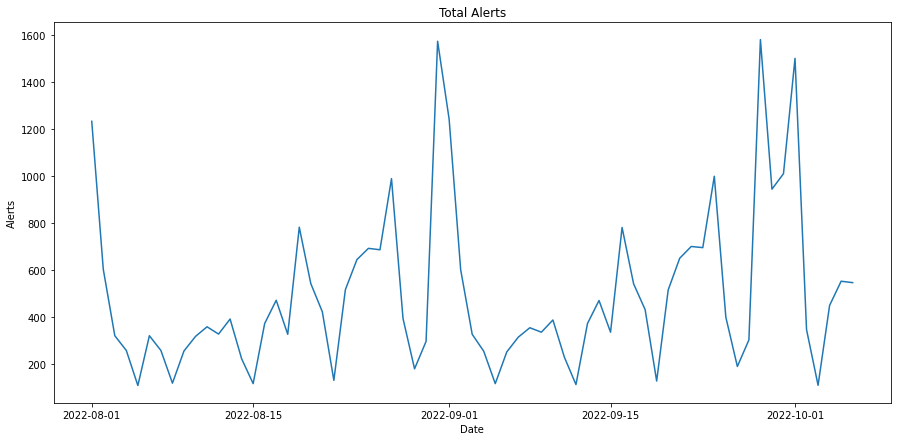

In [55]:
plt.figure(figsize=(15,7))
plt.title("Total Alerts")
plt.xlabel('Date')
plt.ylabel('Alerts')
plt.plot(df)
plt.show()

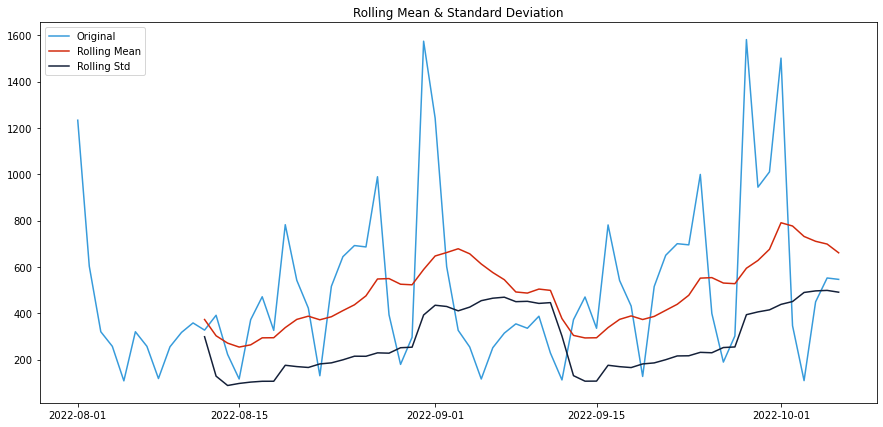

In [56]:
#Determine rolling statistics
df["rolling_avg"] = df["Value"].rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
df["rolling_std"] = df["Value"].rolling(window=12).std()

#Plot rolling statistics
plt.figure(figsize=(15,7))
plt.plot(df["Value"], color='#379BDB', label='Original')
plt.plot(df["rolling_avg"], color='#D22A0D', label='Rolling Mean')
plt.plot(df["rolling_std"], color='#142039', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [57]:
#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(df['Value'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                 -5.138851
p-value                         0.000012
#Lags Used                      1.000000
Number of Observations Used    65.000000
Critical Value (1%)            -3.535217
Critical Value (5%)            -2.907154
Critical Value (10%)           -2.591103
dtype: float64


In [58]:
#Standard ARIMA Model
ARIMA_model = pm.auto_arima(df['Value'], 
                      start_p=1, 
                      start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      seasonal=False, # No Seasonality for standard ARIMA
                      trace=False, #logs 
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)

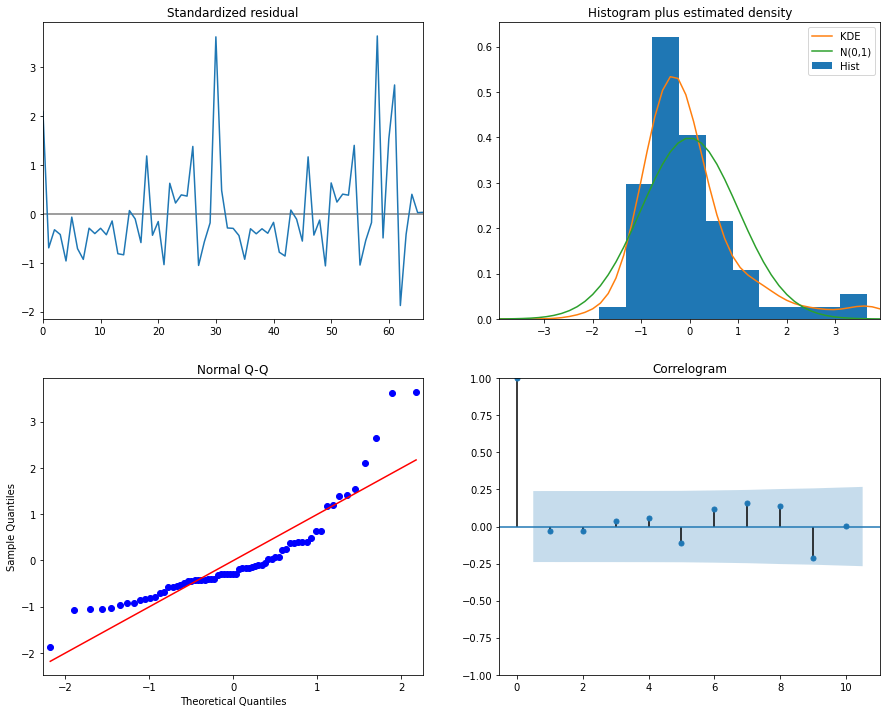

In [59]:
ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

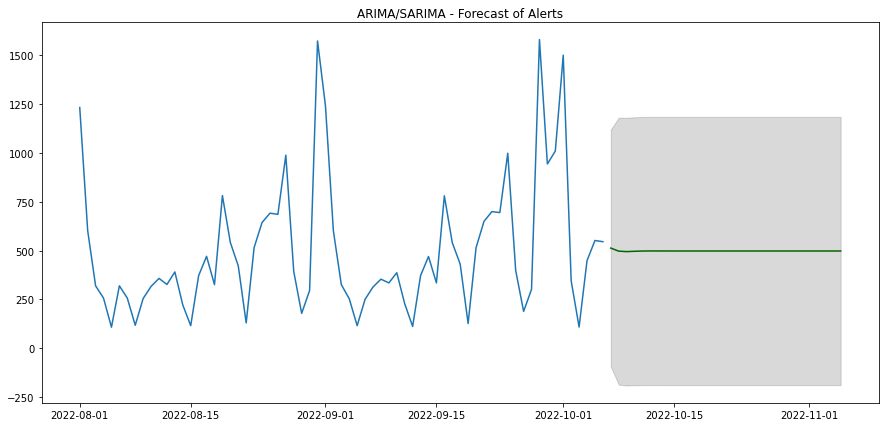

In [82]:
def forecast(ARIMA_model, periods=30):
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(days=1), periods = n_periods, freq='D')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(df["Value"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("ARIMA/SARIMA - Forecast of Alerts")
    plt.show()

forecast(ARIMA_model)

In [104]:
# Seasonal - fit stepwise auto-ARIMA
SARIMA_model = pm.auto_arima(df["Value"], start_p=1, start_q=1,
                         test='adf',
                         max_p=30, max_q=30, 
                         m=30, #30 is the frequncy of the cycle
                         start_P=0, 
                         seasonal=True, #set to seasonal
                         d=None, 
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

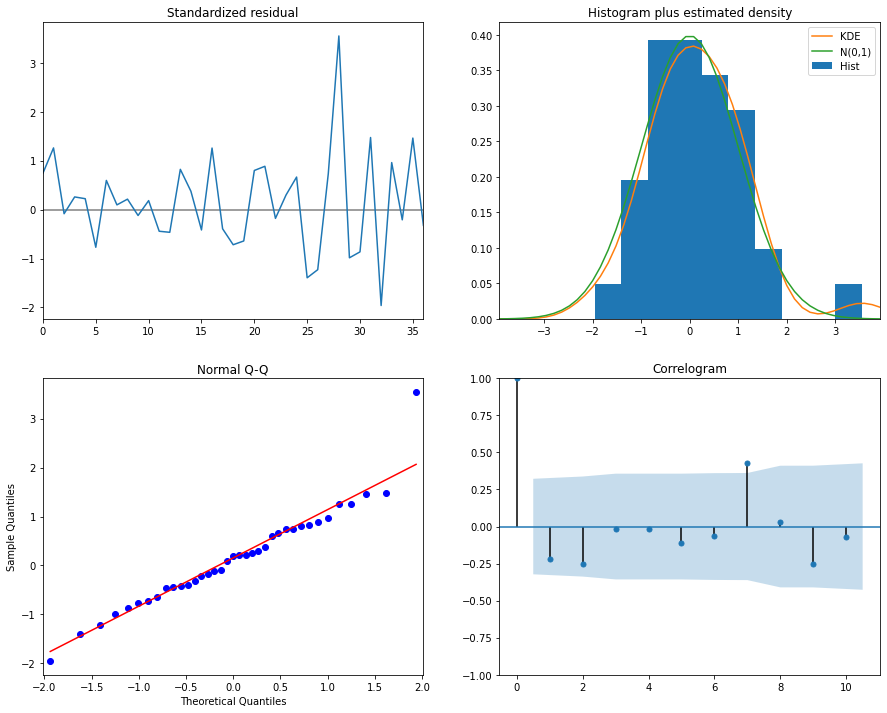

In [105]:
SARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

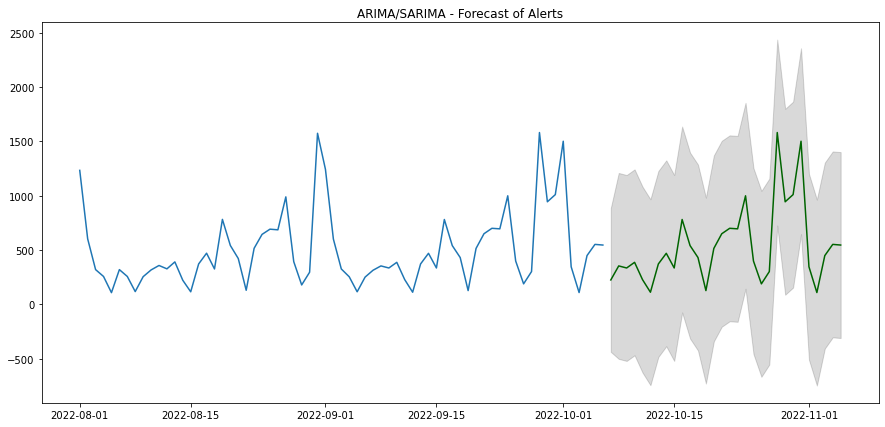

In [106]:
forecast(SARIMA_model)

In [70]:
#adding exogenous variable
df['month_index'] = df.index.month

# SARIMAX Model
SARIMAX_model = pm.auto_arima(df[['Value']], exogenous=df[['month_index']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, 
                           trace=False,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

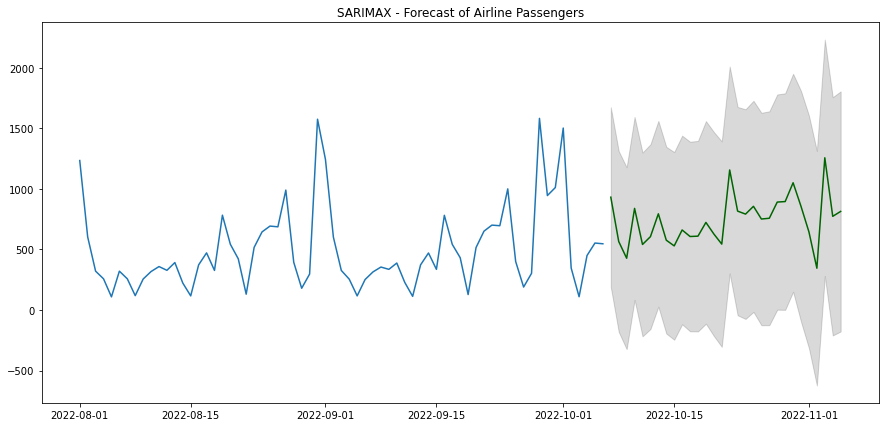

In [93]:
def sarimax_forecast(SARIMAX_model, periods=30):
    # Forecast
    n_periods = periods

    forecast_df = pd.DataFrame({"month_index":pd.date_range(df.index[-1], periods = n_periods, freq='D').month},
                    index = pd.date_range(df.index[-1] + pd.DateOffset(days=1), periods = n_periods, freq='D'))

    fitted, confint = SARIMAX_model.predict(n_periods=n_periods, 
                                            return_conf_int=True,
                                            exogenous=forecast_df[['month_index']])
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(days=1), periods = n_periods, freq='D')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(df["Value"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("SARIMAX - Forecast")
    plt.show()

sarimax_forecast(SARIMAX_model, periods=30)